# SNR finder ANN model training

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from ler.utils import add_dict_values


# Get the number of threads used for intra-operation parallelism
intra_op_threads = tf.config.threading.get_intra_op_parallelism_threads()
print("Default intra-op parallelism threads:", intra_op_threads)

# Get the number of threads used for inter-operation parallelism
inter_op_threads = tf.config.threading.get_inter_op_parallelism_threads()
print("Default inter-op parallelism threads:", inter_op_threads)

Default intra-op parallelism threads: 0
Default inter-op parallelism threads: 0


In [2]:
import tensorflow as tf
print(tf.__version__)
import sklearn as sk
print(sk.__version__)

2.17.0-dev20240514
1.5.0


In [1]:
import tensorflow as tf

tf.config.threading.set_intra_op_parallelism_threads(16)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [2]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['L1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
# unlensed_params['L1']<10000 => Error: 4.13%
# unlensed_params['L1']<100 => Error: 4.05%
# unlensed_params['L1']<50 => Error: 4.16%
idx_constrain = unlensed_params['L1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

len(unlensed_params['L1'])

216908


216856

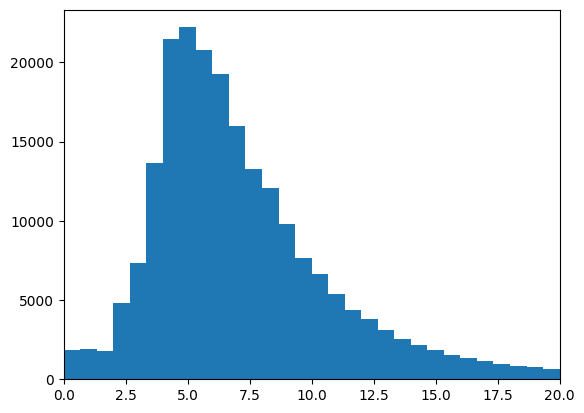

In [3]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['L1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [7]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['L1', 'H1', 'V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10

## Input-Output generator function

In [8]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    # phi_12 = np.array(params['phi_12'])[idx]
    # phi_jl = np.array(params['phi_jl'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    # error=2.41%, 3.60%
    # 4.93%, 3.46%
    # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2]).T
    # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2]).T
    # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2]).T

    # error=2.72%, 3.32%
    # 4.73%, 3.19%
    # 3.20%
    # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # error=2.79%, 3.28%
    # 4.46%, 3.18%
    # 3.27%
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
    XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
    XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

    # output data
    # get L1 snr for y train
    yL1 = params['L1'][idx]
    yH1 = params['H1'][idx]
    yV1 = params['V1'][idx]


    return(XL1, XH1, XV1, yL1, yH1, yV1)

In [76]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get L1 snr for y train
    yL1 = params['L1'][idx]

    return(XL1, yL1)

In [12]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
#XL1, yL1 = input_output(idx, unlensed_params)
XL1, XH1, XV1, yL1, yH1, yV1 = input_output(idx, unlensed_params)
np.shape(XL1)

(216856, 4)

## L1

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

In [14]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [16]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [17]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [18]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 50)

Epoch 1/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 338us/step - accuracy: 3.7072e-08 - loss: 15.8486
Epoch 2/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step - accuracy: 5.8420e-06 - loss: 1.4976
Epoch 3/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 334us/step - accuracy: 1.0833e-05 - loss: 0.7803
Epoch 4/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step - accuracy: 1.0960e-05 - loss: 0.6213
Epoch 5/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step - accuracy: 3.0572e-05 - loss: 0.5921
Epoch 6/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - accuracy: 6.8359e-05 - loss: 0.5740
Epoch 7/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 328us/step - accuracy: 7.0258e-05 - loss: 0.5716
Epoch 8/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 329us/step - accuracy: 7.0232e-05 - loss: 0.5543
Epoch 9/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step - accuracy: 1.5129e-04 - loss: 0.5953
Epoch 10/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 337us/step - accuracy: 9.5283e-05 - loss: 0.5448
Epoch 11/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step -

In [19]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
[[12.37548065 13.22802396]
 [ 8.27327251  8.58878327]
 [13.21272087 13.57709624]
 [ 8.82118797  8.71480813]
 [10.73211098 10.00455053]
 [ 3.16556454  3.03663608]
 [ 7.81873131  8.52726408]
 [ 6.29997301  6.77615418]
 [ 4.1472249   3.73436352]
 [ 5.03977776  5.06585246]
 [ 7.39798164  8.05812022]
 [12.54343224 11.99902287]
 [ 4.9044776   4.50798804]
 [12.63753891 12.01136966]
 [ 9.66114998 10.01966067]]


In [84]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
[[ 6.66560078  6.59797287]
 [13.69468689 15.04932171]
 [ 3.22400141  3.04652657]
 [ 5.72330236  6.05248735]
 [ 7.20016909  7.27926382]
 [ 5.83753681  5.47226447]
 [ 9.7942934   8.82763687]
 [ 5.05551195  5.19874174]
 [10.64801979 10.3965655 ]
 [ 7.06696081  7.38565753]
 [ 7.85827875  7.4171159 ]
 [11.83349609 11.62404837]
 [ 2.76216221  2.58374167]
 [ 6.06088305  5.9833166 ]
 [11.21096992 10.73847873]]


In [20]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.78%


In [85]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.87%


21686
15879


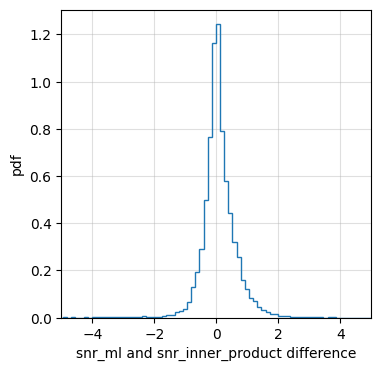

In [86]:
import matplotlib.pyplot as plt

y_pred_ = y_pred.copy().flatten()
# y_test = Y_
hist_ = y_pred_-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<12)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [87]:
# Save the model to a file
ann.save('ann_modelL1.h5')

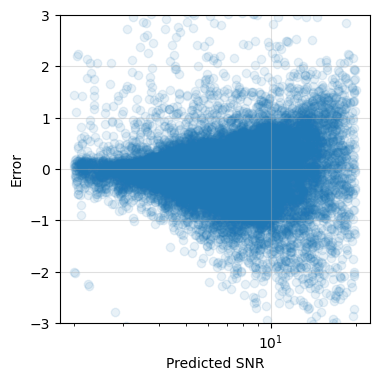

In [21]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

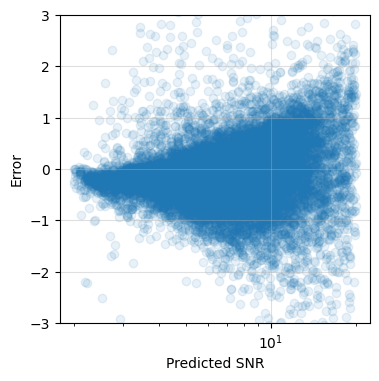

In [88]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## H1

In [89]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['H1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['H1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['H1']))

216908
216853


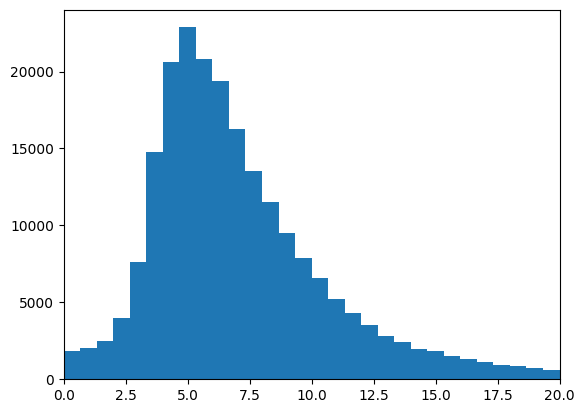

In [90]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['H1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [91]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['H1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['H1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]


In [92]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XH1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get H1 snr for y train
    yH1 = params['H1'][idx]

    return(XH1, yH1)

In [93]:
len_ = len(unlensed_params['H1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XH1, yH1 = input_output(idx, unlensed_params)
np.shape(XH1)

(216853, 5)

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [95]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [96]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [97]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 50)

Epoch 1/50


6099/6099 ━━━━━━━━━━━━━━━━━━━━ 3s 381us/step - accuracy: 0.0000e+00 - loss: 20.3803
Epoch 2/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 353us/step - accuracy: 0.0000e+00 - loss: 1.7726
Epoch 3/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 358us/step - accuracy: 0.0000e+00 - loss: 0.9293
Epoch 4/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 348us/step - accuracy: 0.0000e+00 - loss: 0.6379
Epoch 5/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 336us/step - accuracy: 1.6910e-05 - loss: 0.6340
Epoch 6/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 328us/step - accuracy: 3.5301e-05 - loss: 0.6013
Epoch 7/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 332us/step - accuracy: 5.1284e-05 - loss: 0.5774
Epoch 8/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 328us/step - accuracy: 2.6532e-05 - loss: 0.5785
Epoch 9/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 343us/step - accuracy: 4.8667e-05 - loss: 0.5576
Epoch 10/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step - accuracy: 3.3532e-05 - loss: 0.5639
Epoch 11/50
6099/6099 ━━━━━━━━━━━━━━━━━━━━ 2s 336us/step - accuracy: 

In [98]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
[[ 6.69545746  6.55593315]
 [13.6704874  13.78861126]
 [ 4.97090244  4.94747087]
 [ 6.37660933  6.32663012]
 [ 6.5789361   6.86313318]
 [ 6.12629175  6.06082201]
 [ 4.2740345   4.23106695]
 [ 5.59797001  4.54196594]
 [ 6.52336979  6.62611079]
 [ 3.44532061  6.42821716]
 [ 8.91096687  8.21614632]
 [ 7.22650146  6.70828273]
 [ 1.0004735   0.9392926 ]
 [ 4.21599436  4.3767412 ]
 [19.44013214 18.5320753 ]]


In [99]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 4.25%


In [100]:
# Save the model to a file
ann.save('ann_modelH1.h5')

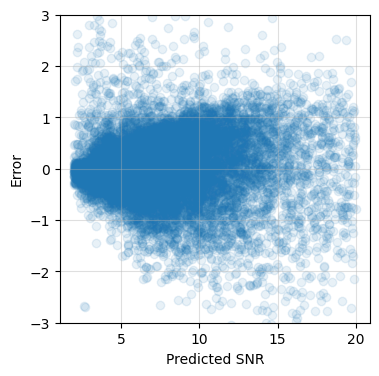

In [101]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
idx = (y_pred_>2) & (y_pred_<20)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_test[idx]-y_pred_[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.savefig("error_vs_snrL1_param4.png")
plt.show()

## V1

In [102]:
# get data
from ler.utils import append_json, get_param_from_json
import numpy as np

# joint two dict
unlensed_params = get_param_from_json("snr_L1.json")
#unlensed_params2 = get_param_from_json("joint_new_optsnr.json")
unlensed_params3 = get_param_from_json("joint_new_optsnr2.json")
unlensed_params4 = get_param_from_json("joint_new_optsnr3.json")
unlensed_params5 = get_param_from_json("joint_new_optsnr4.json")
unlensed_params6 = get_param_from_json("joint_new_optsnr5.json")
unlensed_params7 = get_param_from_json("joint_new_optsnr6.json")
#unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
unlensed_params = add_dict_values(unlensed_params, unlensed_params3)
unlensed_params = add_dict_values(unlensed_params, unlensed_params4)
unlensed_params = add_dict_values(unlensed_params, unlensed_params5)
unlensed_params = add_dict_values(unlensed_params, unlensed_params6)
unlensed_params = add_dict_values(unlensed_params, unlensed_params7)
#del unlensed_params2
del unlensed_params3, unlensed_params4, unlensed_params5, unlensed_params6, unlensed_params7

print(len(unlensed_params['V1']))
# set SNR cut
# this is optimise the ANN by ignoring the high SNR
idx_constrain = unlensed_params['V1']<100
for key, value in unlensed_params.items():
    unlensed_params[key] = value[idx_constrain]

print(len(unlensed_params['V1']))

216908
216879


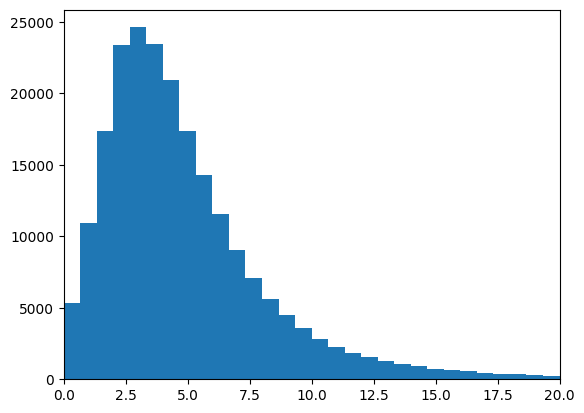

In [103]:
# visualize the data
import matplotlib.pyplot as plt
#unlensed_params = get_param_from_json("joint_new_optsnr.json")
test = np.array(unlensed_params['V1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [104]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', ifos=['V1'])

You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_5.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['V1']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_psd.txt', asd_file='None')]


In [105]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    XV1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T 

    # output data
    # get V1 snr for y train
    yV1 = params['V1'][idx]

    return(XV1, yV1)

In [106]:
len_ = len(unlensed_params['V1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XV1, yV1 = input_output(idx, unlensed_params)
np.shape(XV1)

(216879, 5)

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [108]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [109]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [110]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 50)

Epoch 1/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 390us/step - accuracy: 1.0081e-05 - loss: 8.4084
Epoch 2/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 375us/step - accuracy: 3.8943e-05 - loss: 0.9694
Epoch 3/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step - accuracy: 2.1626e-05 - loss: 0.6412
Epoch 4/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 364us/step - accuracy: 2.9661e-05 - loss: 0.4326
Epoch 5/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 3s 478us/step - accuracy: 3.8418e-05 - loss: 0.4578
Epoch 6/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 360us/step - accuracy: 6.8986e-05 - loss: 0.4319
Epoch 7/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 352us/step - accuracy: 8.7941e-05 - loss: 0.3476
Epoch 8/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 351us/step - accuracy: 3.1850e-05 - loss: 0.3270
Epoch 9/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 357us/step - accuracy: 2.4314e-05 - loss: 0.3407
Epoch 10/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step - accuracy: 2.8571e-05 - loss: 0.3357
Epoch 11/50
6100/6100 ━━━━━━━━━━━━━━━━━━━━ 2s 356us/step - 

In [111]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
[[ 1.53377843  1.34845989]
 [ 8.82300472  9.42342284]
 [ 9.23123932  9.50176964]
 [ 6.78109932  6.71383349]
 [ 3.45597482  2.93182674]
 [20.84974289 19.43452293]
 [ 4.82222366  4.45898888]
 [ 6.56668997  5.78575818]
 [ 7.9428587   7.79091512]
 [11.99186897 12.42393706]
 [ 6.40109825  6.35905328]
 [ 1.48564267  1.4002833 ]
 [13.96557426 13.13723521]
 [ 4.06244326  4.07008846]
 [ 5.06959343 10.54694632]]


In [112]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.92%


In [113]:
# Save the model to a file
ann.save('ann_modelV1.h5')

## Load all models and test them

In [10]:
load_model?

Signature: load_model(filepath, custom_objects=None, compile=True, safe_mode=True)
Docstring:
Loads a model saved via `model.save()`.

Args:
    filepath: `str` or `pathlib.Path` object, path to the saved model file.
    custom_objects: Optional dictionary mapping names
        (strings) to custom classes or functions to be
        considered during deserialization.
    compile: Boolean, whether to compile the model after loading.
    safe_mode: Boolean, whether to disallow unsafe `lambda` deserialization.
        When `safe_mode=False`, loading an object has the potential to
        trigger arbitrary code execution. This argument is only
        applicable to the Keras v3 model format. Defaults to `True`.

Returns:
    A Keras model instance. If the original model was compiled,
    and the argument `compile=True` is set, then the returned model
    will be compiled. Otherwise, the model will be left uncompiled.

Example:

```python
model = keras.Sequential([
    keras.layers.Dense(5, 

In [24]:
from tensorflow.keras.models import load_model

modelL1 = load_model('ann_modelL1.h5', compile=False)
modelH1 = load_model('ann_modelH1.h5', compile=False)
modelV1 = load_model('ann_modelV1.h5', compile=False)

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

## BBH

In [25]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
You have chosen default ANN model. This model only works for gwsnr default parameters.
ANN model will be save and loaded from 'ann_data' directory. To create new model, follow instructions from the 'gwsnr' documentation.
Please be patient while the interpolator is generated for partialscaledSNR.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpam

In [26]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff, theta_jn]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff, theta_jn]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff, theta_jn]).T    

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(np.array(params['L1'])[idx]**2 + np.array(params['H1'])[idx]**2 + np.array(params['V1'])[idx]**2)

    # taking care mtot max
    # mtot_max = gwsnr.mtot_max
    # mtot = mass_1[idx] + mass_2[idx]
    # y[mtot>mtot_max] = 0.

    return(X,y)

In [27]:
# generating new data
from ler.rates import LeR
from ler.utils import get_param_from_json
import numpy as np

ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True, z_max=5)

In [28]:
## Uncomment to generate new data if not already generated
size_ = 25000
ler.batch_size = 25000
ler.unlensed_cbc_statistics(size=size_, output_jsonfile='unlensed_param_testing.json', resume=True);

unlensed params will be store in ./ler_data/unlensed_param_testing.json
chosen batch size = 25000 with total size = 25000
There will be 1 batche(s)
resuming from ./ler_data/unlensed_param_testing.json
saving all unlensed_params in ./ler_data/unlensed_param_testing.json 


In [29]:
unlensed_params = get_param_from_json("ler_data/unlensed_param_testing.json")

In [30]:
X_, Y_ = input_output_net(np.arange(size_), unlensed_params)

In [31]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)

    mass_1 = np.array(unlensed_params['mass_1'])
    mass_2 = np.array(unlensed_params['mass_2'])
    mtot = mass_1 + mass_2
    y[mtot>gwsnr.mtot_max] = 0.

    return(x_array,y)

In [32]:
_, snrANN =input_output_netANN(X_)

In [33]:
y_pred = snrANN.flatten()
y_test = Y_

In [124]:
len(y_test)

25000

In [125]:
len(y_pred)

25000

In [126]:
# do linear fitting of the error y_pred-y_test
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

idx = (y_pred_>4) & (y_pred_<12)
popt, pcov = curve_fit(func, y_pred[idx], y_pred[idx]-y_test[idx])
print(popt)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 25000 but corresponding boolean dimension is 21686

In [ ]:
# looking correlation between error and snr
import matplotlib.pyplot as plt
y_pred_ = y_pred.copy().flatten()
y_pred_ = y_pred_-(popt[0]*y_pred+popt[1])
idx = (y_pred_>4) & (y_pred_<12)
plt.figure(figsize=(4,4))
plt.scatter(y_pred_[idx], y_pred_[idx]-y_test[idx], alpha=0.1)
#plt.scatter(y_test[idx], y_pred_[idx]-y_test[idx], alpha=0.1)
plt.xlabel("Predicted SNR")
#plt.xscale("log")
plt.xlim(4,10)
plt.ylabel("Error")
plt.ylim(-3,3)
plt.grid(alpha=0.4)
plt.show()

NameError: name 'popt' is not defined

25000
777


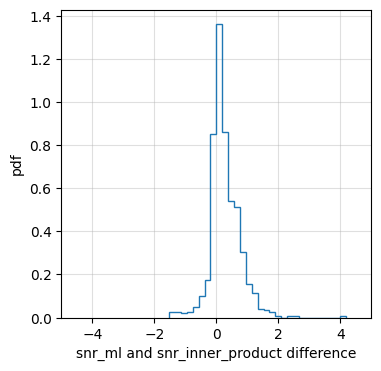

In [ ]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [ ]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

Error: 0.1160%


In [ ]:
len1 = len(y_pred)
len2 = np.sum(((y_pred-(popt[0]*y_pred+popt[1]))>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.4f}%")

NameError: name 'popt' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.0)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24868    19]
 [   10   103]]


0.99884

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), ((y_pred-0.2)>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[24871    16]
 [   12   101]]


0.99884

In [ ]:
#y_pred = (y_pred > 0.5)
idx = (y_test>7) & (y_pred<9)
print(np.concatenate((y_pred.reshape(len(y_pred),1)-0.2, y_test.reshape(len(y_test),1)),1)[idx][:10])

[[7.12779617 7.3244188 ]
 [8.20918941 8.73664642]
 [8.73628235 9.05212486]
 [6.84442377 7.01070622]
 [8.05471325 8.33806557]
 [7.78671503 8.45750222]
 [8.7175951  8.94146165]
 [8.44607449 7.33984516]
 [7.89227676 7.59029936]
 [6.74918747 7.04858059]]


## BNS

In [540]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [541]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


  1%|▌                                                          | 527/50000 [00:10<17:00, 48.47it/s]


KeyboardInterrupt: 

In [ ]:
from ler.utils import get_param_from_json
unlensed_params = get_param_from_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined